# Computer simulations course 2018/2019-2 @ ELTE
# Assignment 3: Planetary Motions - Two body problem
## 03.03.2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats
import time
import imageio
import os, shutil
from matplotlib.patches import Circle

In [2]:
sns.set_style(style='whitegrid')

### Planets

In [3]:
Planets={
    'Sun': [1.989e30, 0, 0.0001],
    'Moon': [7.348e22, 0.00257, 0.0549],
    'Mercury': [3.285e23, 0.466697, 0.205630],
    'Venus': [4.867e24, 0.728213, 0.006772],
    'Earth': [5.972e24, 1.017, 0.0167086],
    'Mars': [6.39e23, 1.666, 0.0934],
    'Jupiter': [1.898e27, 5.4588, 0.0489],
    'Saturn': [5.683e26, 10.1238, 0.0565],
    'Uranus': [8.681e25, 20.11, 0.046381],
    'Neptune': [1.024e26, 30.33, 0.009456],
    'Pluto': [1.309e22, 49.305, 0.2488],
    'Halley': [2.2e14, 35.082, 0.96714]
}

## Initial conditions

In [30]:
choosen_planet_1 = 'Earth'
choosen_planet_2 = 'Earth'
if(choosen_planet_1 != ''):
    m_1 = Planets[choosen_planet_1][0]
else:
    m_1 = Planets['Saturn'][0]

if(choosen_planet_2 != ''):
    m_2 = 2 * Planets[choosen_planet_2][0]
else:
    m_2 = Planets['Jupiter'][0]
# Eccentricity
if(choosen_planet_1 != ''):
    ecc_1 = Planets[choosen_planet_1][2]
else:
    ecc_1 = 0.3
if(choosen_planet_2 != ''):
    ecc_2 = Planets[choosen_planet_2][2]
else:
    ecc_2 = 0.5

# Distance of planets in AU
r_dist = Planets[choosen_planet_2][1]

# Step size
dt = 1e-3
# Adaptive accuracy of simulation
accuracy = 1e-5

# Calculated orbit parameters
# a: semi-major axis in [AU]
# b: semi-minor axis in [AU]
r_ap_1 = m_2/(m_1+m_2) * r_dist
r_ap_2 = r_dist - r_ap_1
a_1 = r_ap_1 / (1 + ecc_1)
a_2 = r_ap_2 / (1 + ecc_2)
b_1 = np.sqrt(1 - ecc_1**2) * a_1
b_2 = np.sqrt(1 - ecc_2**2) * a_2
v0_1 = np.sqrt(4 * np.pi * np.pi * (2 / r_ap_1 - 1 / a_1))  # Initial velocity of first body (tangential along y-axis) [AU/day]
v0_2 = np.sqrt(4 * np.pi * np.pi * (2 / r_ap_2 - 1 / a_2))  # Initial velocity of second body (tangential along y-axis) [AU/day]

# Orbital period in [years]
T_2 = np.power(a_2, 3/2);
T_1 = T_2;

# Number of years to plot
plotting_years = max(T_1, T_2) * 1

# Others
steps = 1
image_dpi = 150
image_format = 'png'
image_path = '..\\Documentation\\src\\images\\two_body\\'

In [31]:
2 * r_ap_1 * np.pi/1

4.259999638267759

In [32]:
v0_2

10.700920550919406

In [33]:
def mode_choose(mode, odeint, relat):
    
    current_mode = ('..\Release\kepler_two.exe ' +
                    mode + ' ' +
                    odeint + ' ' +
                    relat + ' ' +
                    str(m_1) + ' ' +
                    str(m_2) + ' ' +
                    str(r_dist) + ' ' +
                    str(ecc_1) + ' ' +
                    str(ecc_2) + ' ' +
                    str(plotting_years) + ' ' +
                    str(dt) + ' ' +
                    str(accuracy)
                   )

    return(current_mode)

In [34]:
current_mode = mode_choose(mode = 'fixed', odeint='rkck', relat='relat')
os.system(current_mode)
data_fixed = np.genfromtxt('fixed.dat')

current_mode = mode_choose(mode = 'adaptive', odeint='rkck', relat='no')
os.system(current_mode)
data_adaptive = np.genfromtxt('adaptive.dat')

## Time propagation of coordinates and velocities

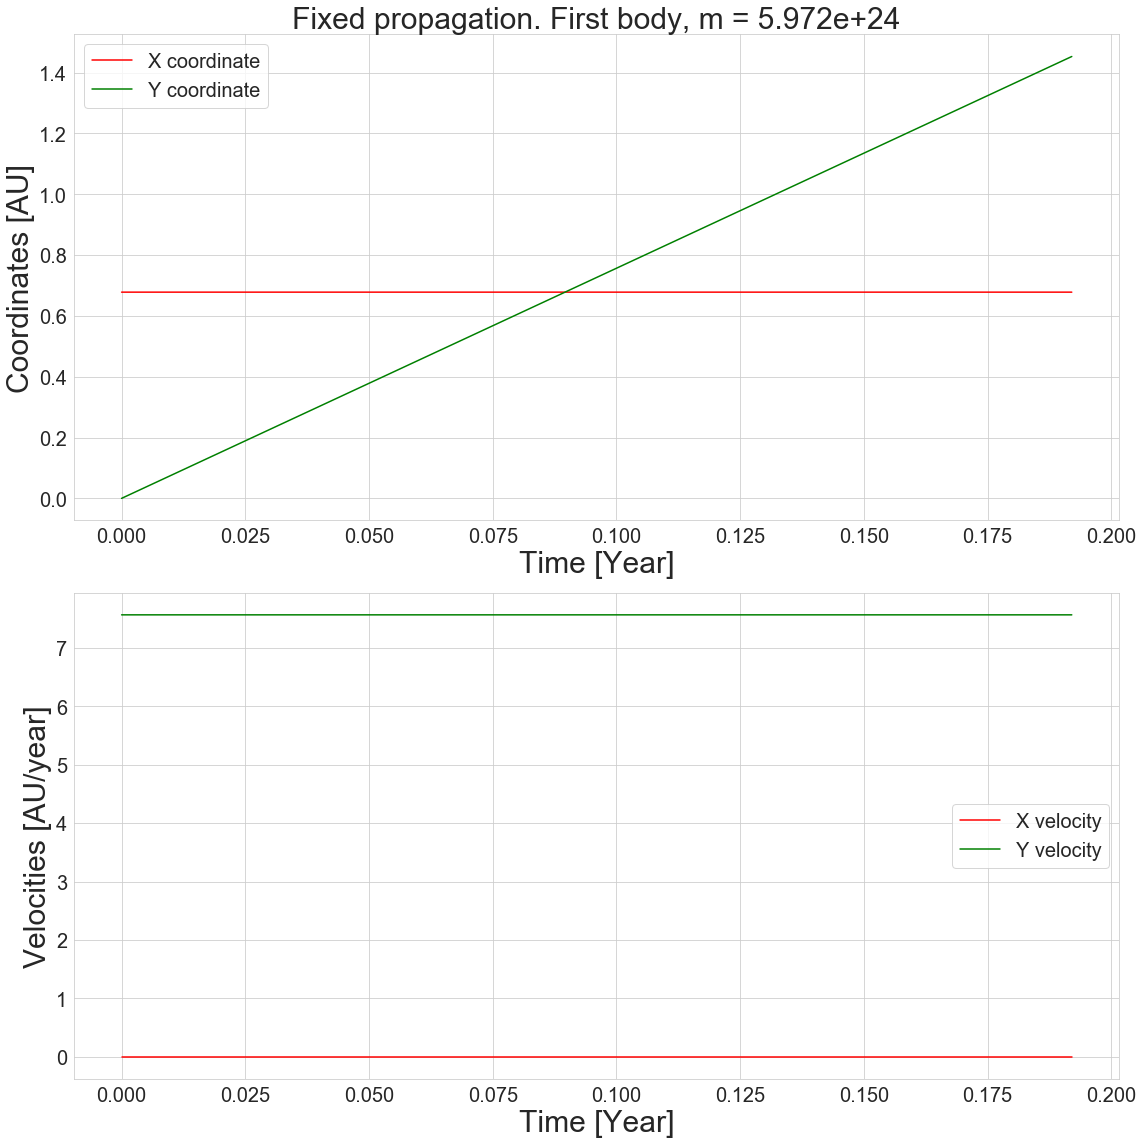

In [35]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*16,nrows*8))

axes[0].plot(data_fixed[::steps,0], data_fixed[::steps,1], c='red', label='X coordinate')
axes[0].plot(data_fixed[::steps,0], data_fixed[::steps,2], c='green', label='Y coordinate')
axes[1].plot(data_fixed[::steps,0], data_fixed[::steps,3], c='red', label='X velocity')
axes[1].plot(data_fixed[::steps,0], data_fixed[::steps,4], c='green', label='Y velocity')

axes[0].set_title('Fixed propagation. First body, m = {0}'.format(m_1), fontsize=30)

axes[0].set_xlabel('Time [Year]', fontsize=30)
axes[0].set_ylabel('Coordinates [AU]', fontsize=30)
axes[1].set_xlabel('Time [Year]', fontsize=30)
axes[1].set_ylabel('Velocities [AU/year]', fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

axes[0].legend(fontsize=20)
axes[1].legend(fontsize=20)

fig.tight_layout()
plt.show()

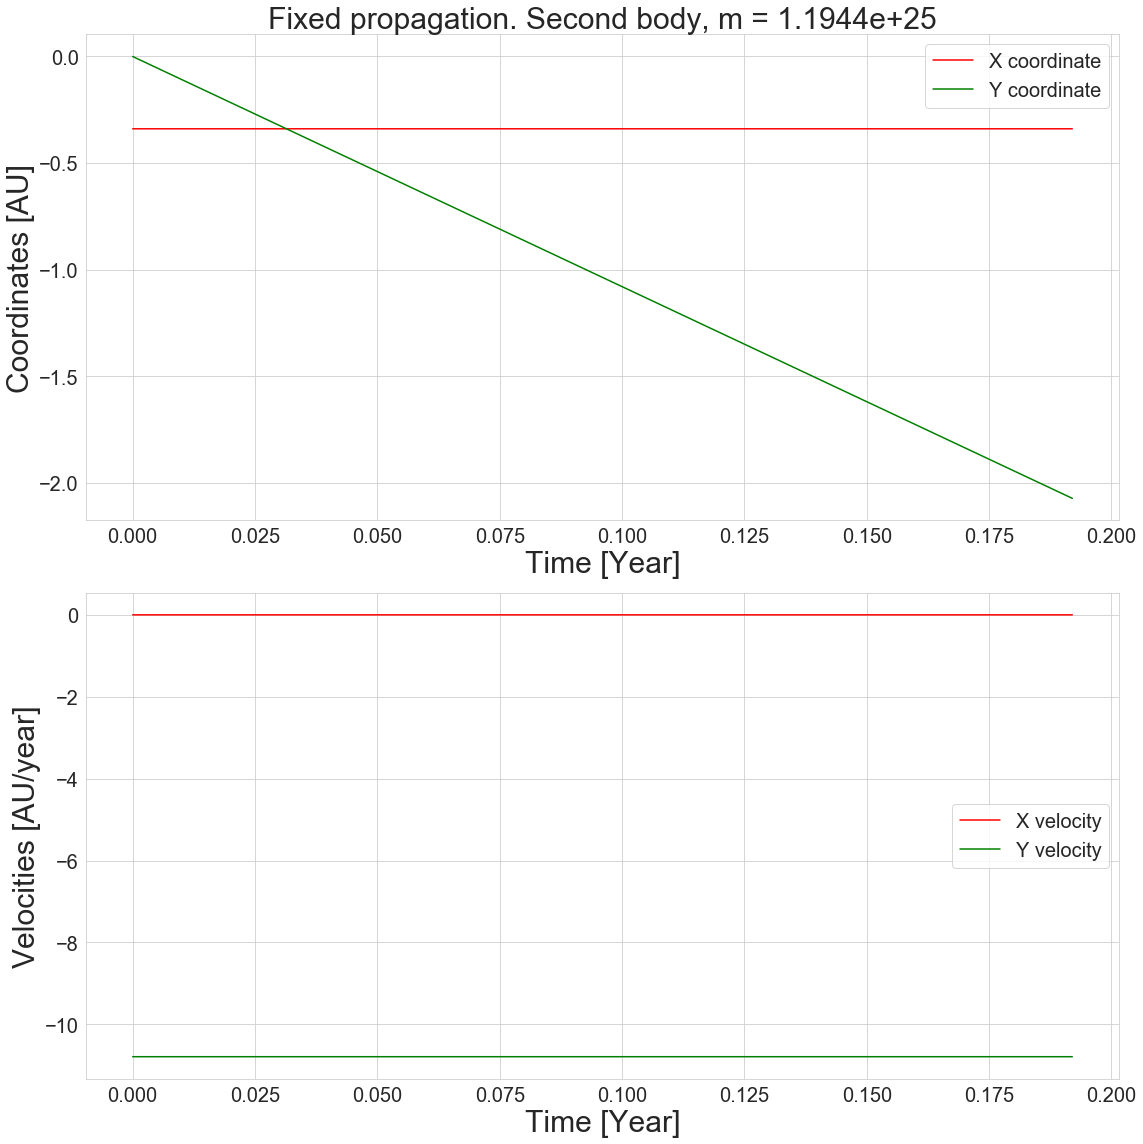

In [36]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*16,nrows*8))

axes[0].plot(data_fixed[::steps,0], data_fixed[::steps,6], c='red', label='X coordinate')
axes[0].plot(data_fixed[::steps,0], data_fixed[::steps,7], c='green', label='Y coordinate')
axes[1].plot(data_fixed[::steps,0], data_fixed[::steps,8], c='red', label='X velocity')
axes[1].plot(data_fixed[::steps,0], data_fixed[::steps,9], c='green', label='Y velocity')

axes[0].set_title('Fixed propagation. Second body, m = {0}'.format(m_2), fontsize=30)

axes[0].set_xlabel('Time [Year]', fontsize=30)
axes[0].set_ylabel('Coordinates [AU]', fontsize=30)
axes[1].set_xlabel('Time [Year]', fontsize=30)
axes[1].set_ylabel('Velocities [AU/year]', fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

axes[0].legend(fontsize=20)
axes[1].legend(fontsize=20)

fig.tight_layout()
plt.show()

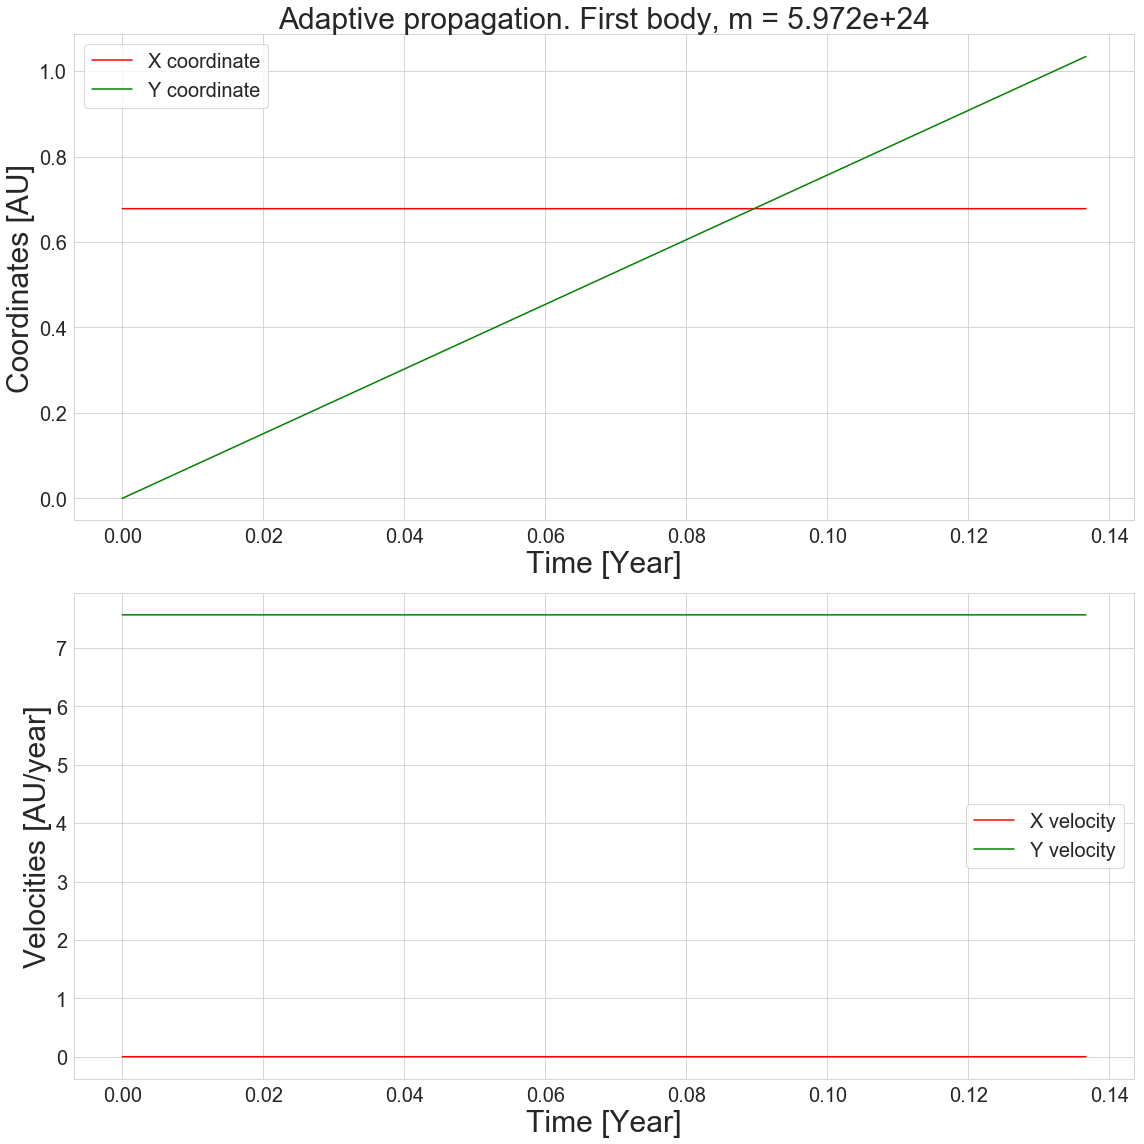

In [37]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*16,nrows*8))

axes[0].plot(data_adaptive[::steps,0], data_adaptive[::steps,1], c='red', label='X coordinate')
axes[0].plot(data_adaptive[::steps,0], data_adaptive[::steps,2], c='green', label='Y coordinate')
axes[1].plot(data_adaptive[::steps,0], data_adaptive[::steps,3], c='red', label='X velocity')
axes[1].plot(data_adaptive[::steps,0], data_adaptive[::steps,4], c='green', label='Y velocity')

axes[0].set_title('Adaptive propagation. First body, m = {0}'.format(m_1), fontsize=30)

axes[0].set_xlabel('Time [Year]', fontsize=30)
axes[0].set_ylabel('Coordinates [AU]', fontsize=30)
axes[1].set_xlabel('Time [Year]', fontsize=30)
axes[1].set_ylabel('Velocities [AU/year]', fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

axes[0].legend(fontsize=20)
axes[1].legend(fontsize=20)

fig.tight_layout()
plt.show()

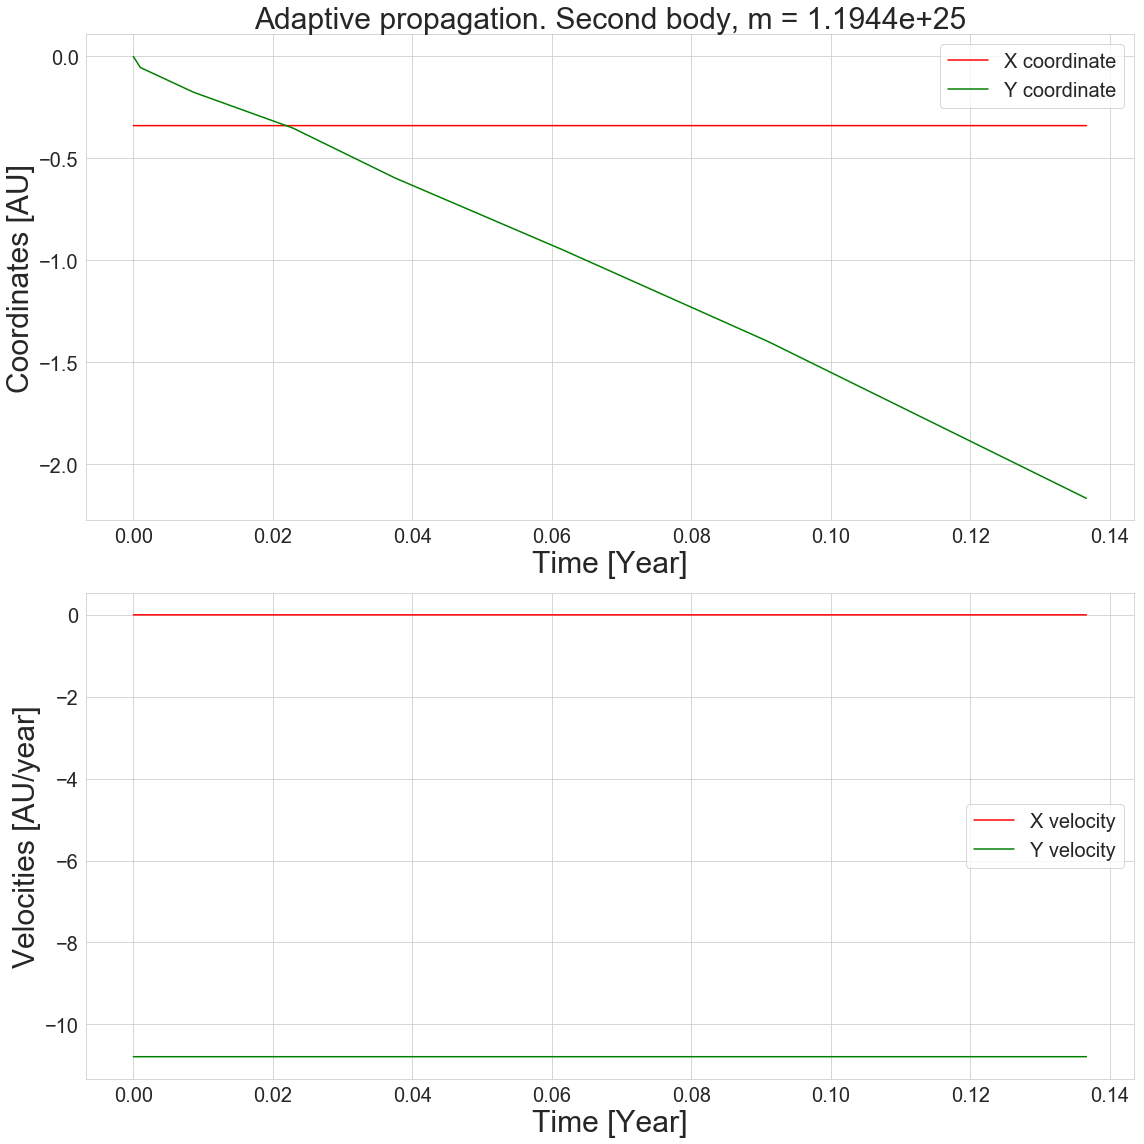

In [38]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*16,nrows*8))

axes[0].plot(data_adaptive[::steps,0], data_adaptive[::steps,6], c='red', label='X coordinate')
axes[0].plot(data_adaptive[::steps,0], data_adaptive[::steps,7], c='green', label='Y coordinate')
axes[1].plot(data_adaptive[::steps,0], data_adaptive[::steps,8], c='red', label='X velocity')
axes[1].plot(data_adaptive[::steps,0], data_adaptive[::steps,9], c='green', label='Y velocity')

axes[0].set_title('Adaptive propagation. Second body, m = {0}'.format(m_2), fontsize=30)

axes[0].set_xlabel('Time [Year]', fontsize=30)
axes[0].set_ylabel('Coordinates [AU]', fontsize=30)
axes[1].set_xlabel('Time [Year]', fontsize=30)
axes[1].set_ylabel('Velocities [AU/year]', fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

axes[0].legend(fontsize=20)
axes[1].legend(fontsize=20)

fig.tight_layout()
plt.show()

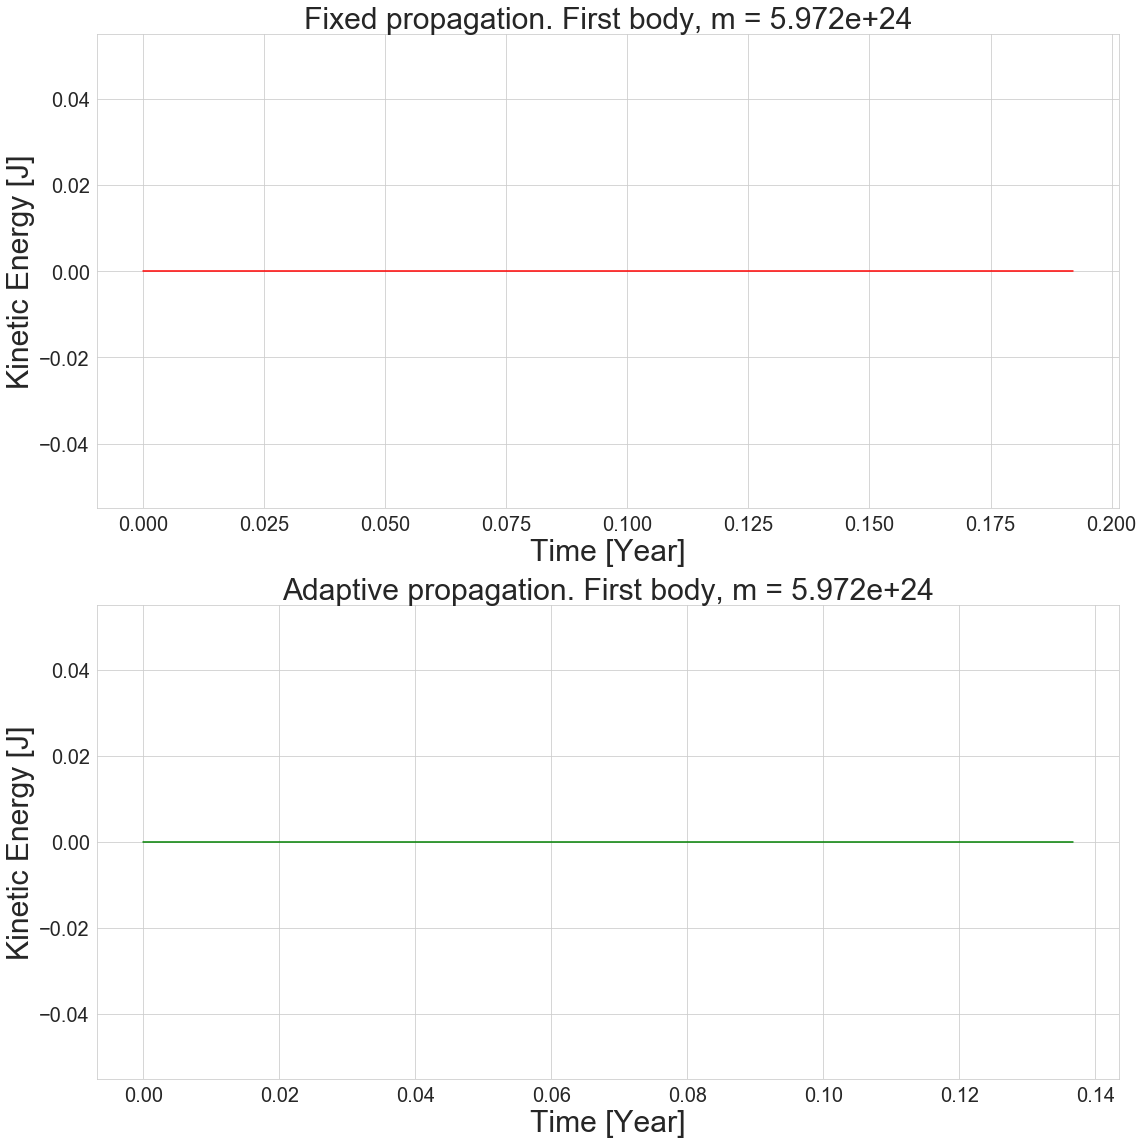

In [39]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*16,nrows*8))

axes[0].plot(data_fixed[::steps,0], data_fixed[::steps,10], c='red')
axes[1].plot(data_adaptive[::steps,0], data_adaptive[::steps,10], c='green')

axes[0].set_title('Fixed propagation. First body, m = {0}'.format(m_1), fontsize=30)
axes[1].set_title('Adaptive propagation. First body, m = {0}'.format(m_1), fontsize=30)

axes[0].set_xlabel('Time [Year]', fontsize=30)
axes[0].set_ylabel('Kinetic Energy [J]', fontsize=30)
axes[1].set_xlabel('Time [Year]', fontsize=30)
axes[1].set_ylabel('Kinetic Energy [J]', fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.show()

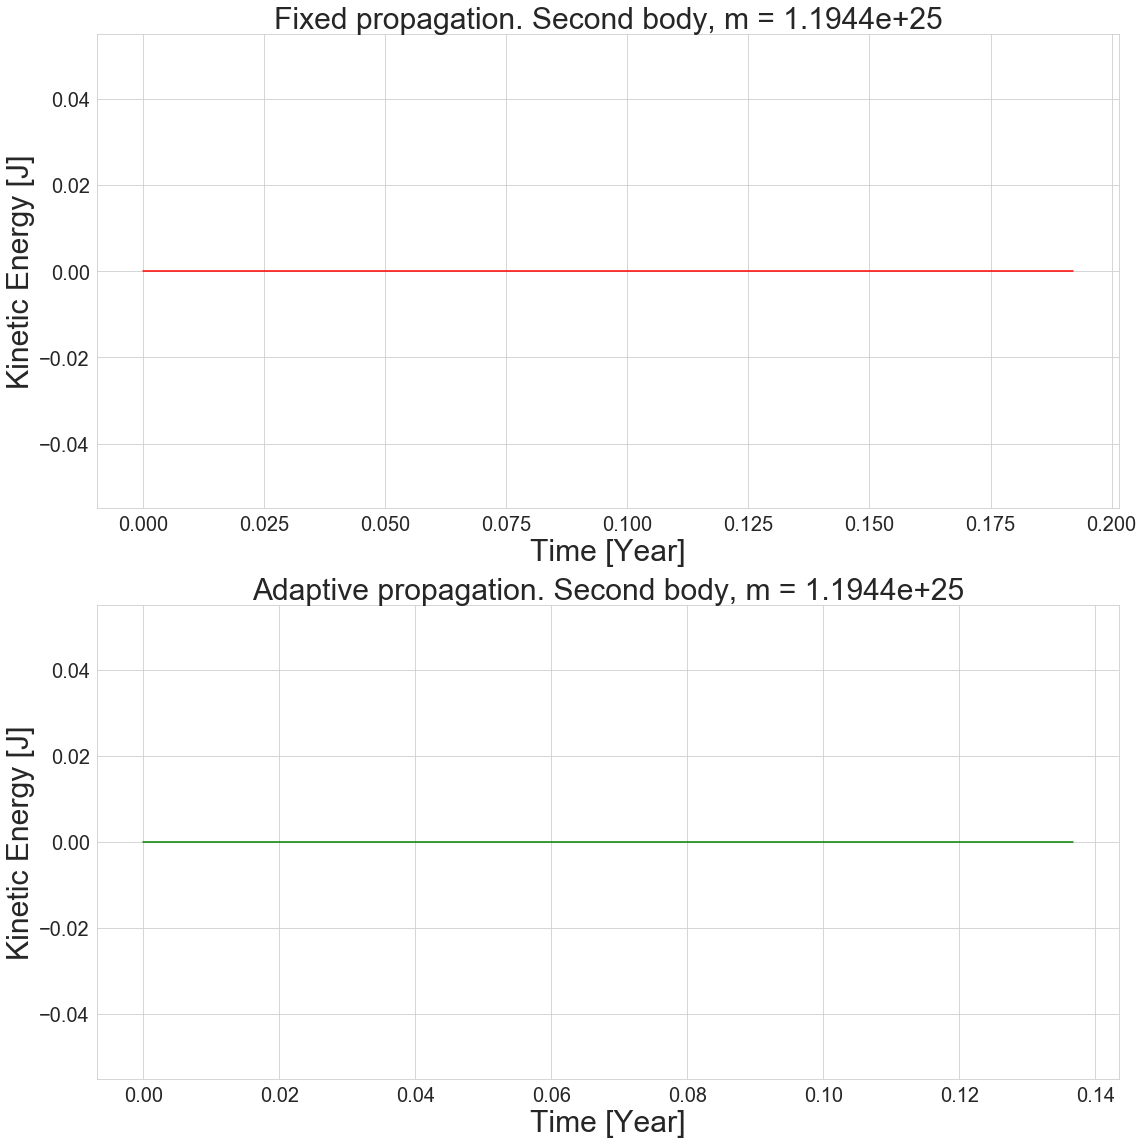

In [40]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*16,nrows*8))

axes[0].plot(data_fixed[0:,0], data_fixed[0:,11], c='red')
axes[1].plot(data_adaptive[0:,0], data_adaptive[0:,11], c='green')

axes[0].set_title('Fixed propagation. Second body, m = {0}'.format(m_2), fontsize=30)
axes[1].set_title('Adaptive propagation. Second body, m = {0}'.format(m_2), fontsize=30)

axes[0].set_xlabel('Time [Year]', fontsize=30)
axes[0].set_ylabel('Kinetic Energy [J]', fontsize=30)
axes[1].set_xlabel('Time [Year]', fontsize=30)
axes[1].set_ylabel('Kinetic Energy [J]', fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.show()

## Orbit of choosen Planets

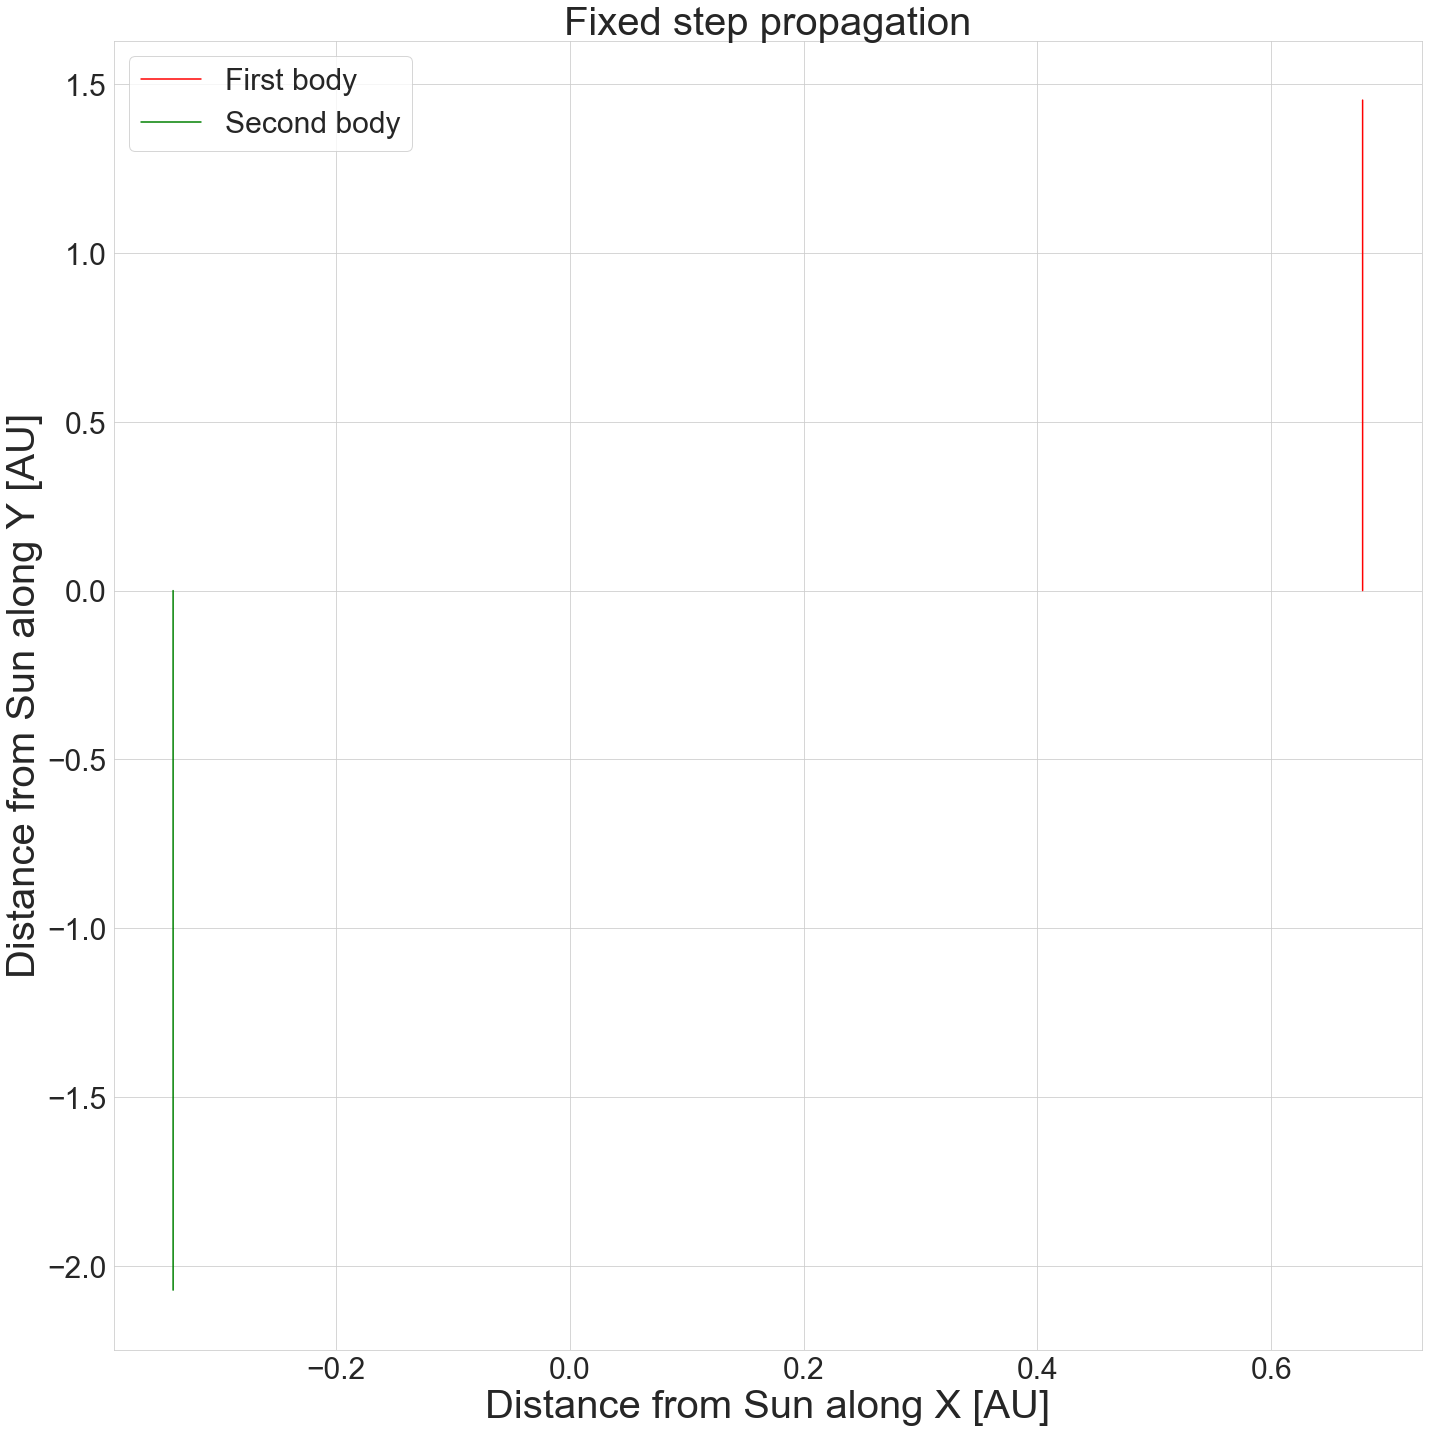

In [41]:
nrows = 1
ncols = 1
picsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(picsize,picsize))

axes.plot(data_fixed[::steps,1], data_fixed[::steps,2], c='red', label='First body')
axes.plot(data_fixed[::steps,6], data_fixed[::steps,7], c='green', label='Second body')

#axes.set_xlim(min(min(data_fixed[::steps,1]), min(data_fixed[::steps,6])),max(max(data_fixed[::steps,1]), max(data_fixed[::steps,6])))
#axes.set_ylim(min(min(data_fixed[::steps,2]), min(data_fixed[::steps,7])),max(max(data_fixed[::steps,2]), max(data_fixed[::steps,7])))

axes.set_title('Fixed step propagation', fontsize=40)

axes.set_xlabel('Distance from Sun along X [AU]', fontsize=40)
axes.set_ylabel('Distance from Sun along Y [AU]', fontsize=40)

axes.tick_params(axis='both', which='major', labelsize=30)

axes.legend(fontsize=30)
fig.tight_layout()
plt.savefig(image_path +
            'two_body_orbit' + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

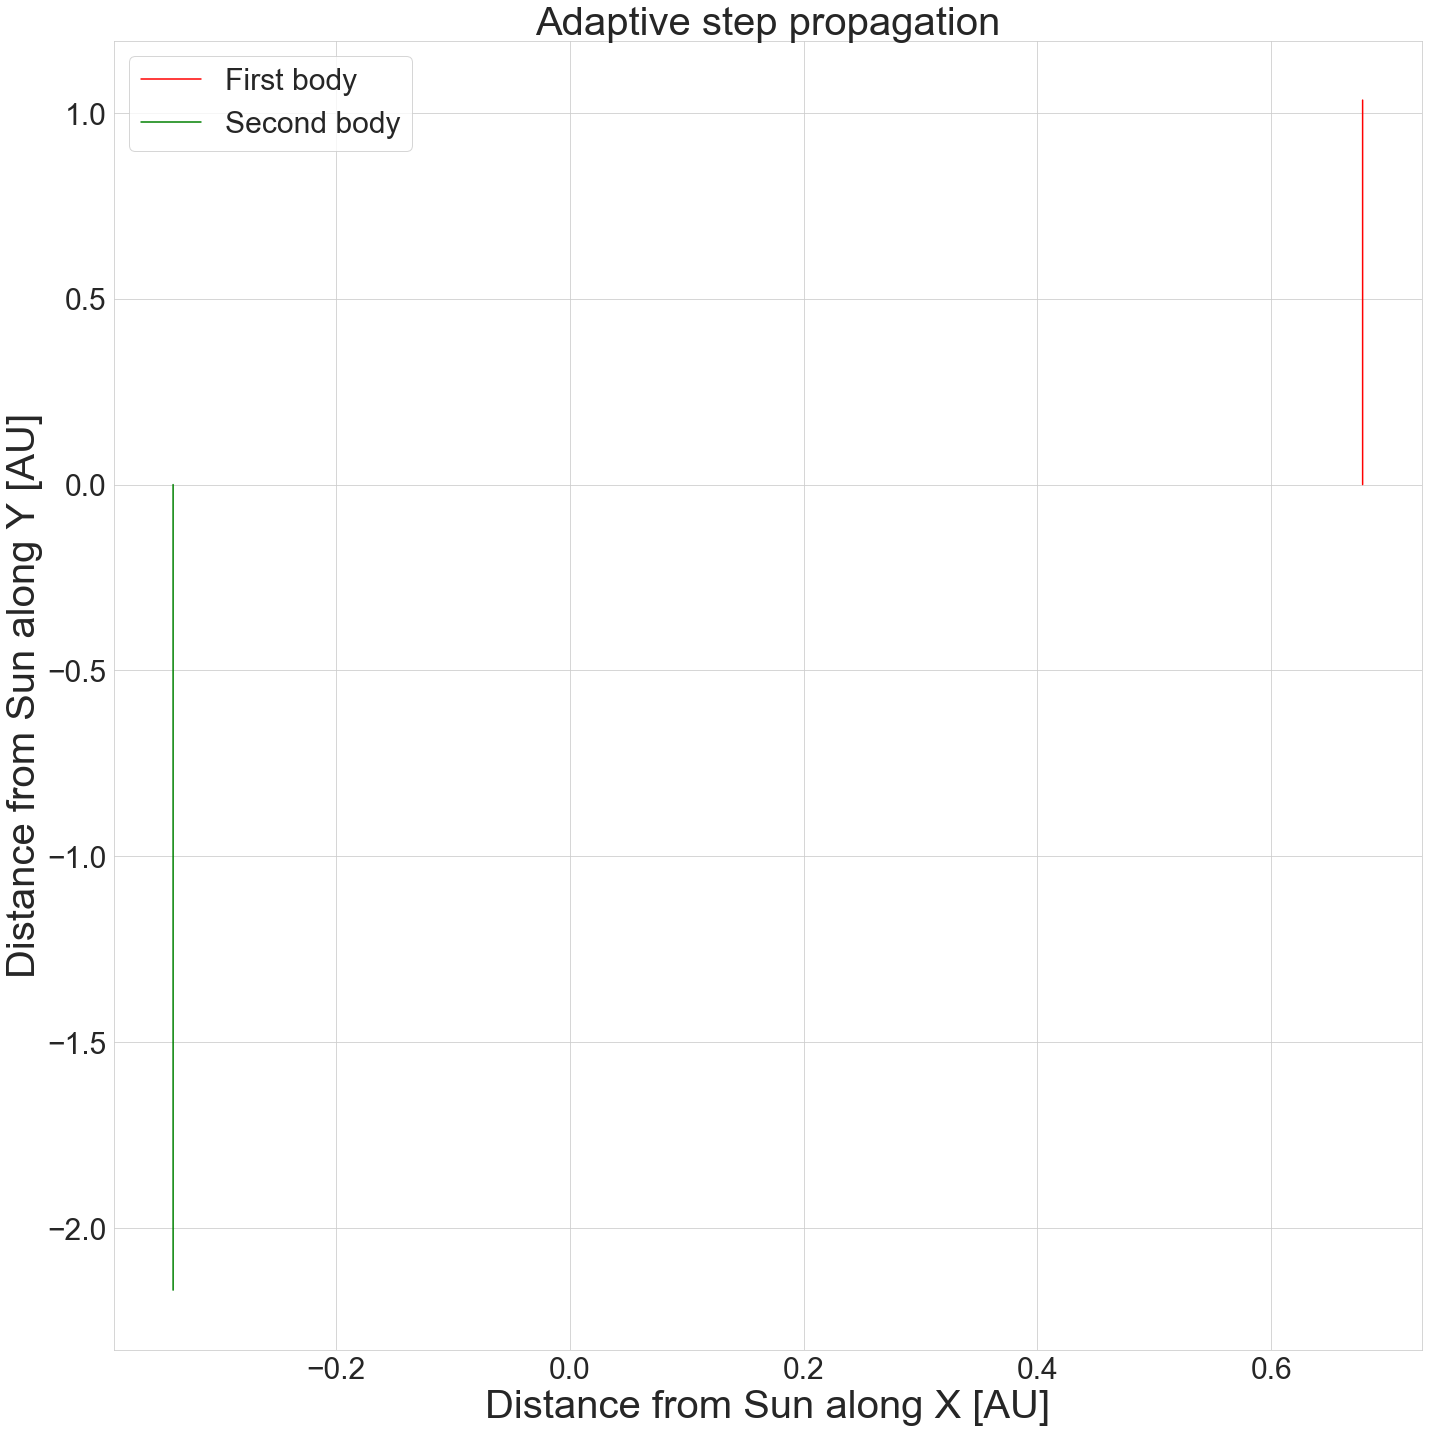

In [42]:
nrows = 1
ncols = 1
picsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(picsize,picsize))

axes.plot(data_adaptive[::steps,1], data_adaptive[::steps,2], c='red', label='First body')
axes.plot(data_adaptive[::steps,6], data_adaptive[::steps,7], c='green', label='Second body')

#axes.set_xlim(min(min(data_fixed[::steps,1]), min(data_fixed[::steps,6])),max(max(data_fixed[::steps,1]), max(data_fixed[::steps,6])))
#axes.set_ylim(min(min(data_fixed[::steps,2]), min(data_fixed[::steps,7])),max(max(data_fixed[::steps,2]), max(data_fixed[::steps,7])))

axes.set_title('Adaptive step propagation', fontsize=40)

axes.set_xlabel('Distance from Sun along X [AU]', fontsize=40)
axes.set_ylabel('Distance from Sun along Y [AU]', fontsize=40)

axes.tick_params(axis='both', which='major', labelsize=30)

axes.legend(fontsize=30)
fig.tight_layout()
plt.savefig(image_path +
            'two_body_orbit' + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

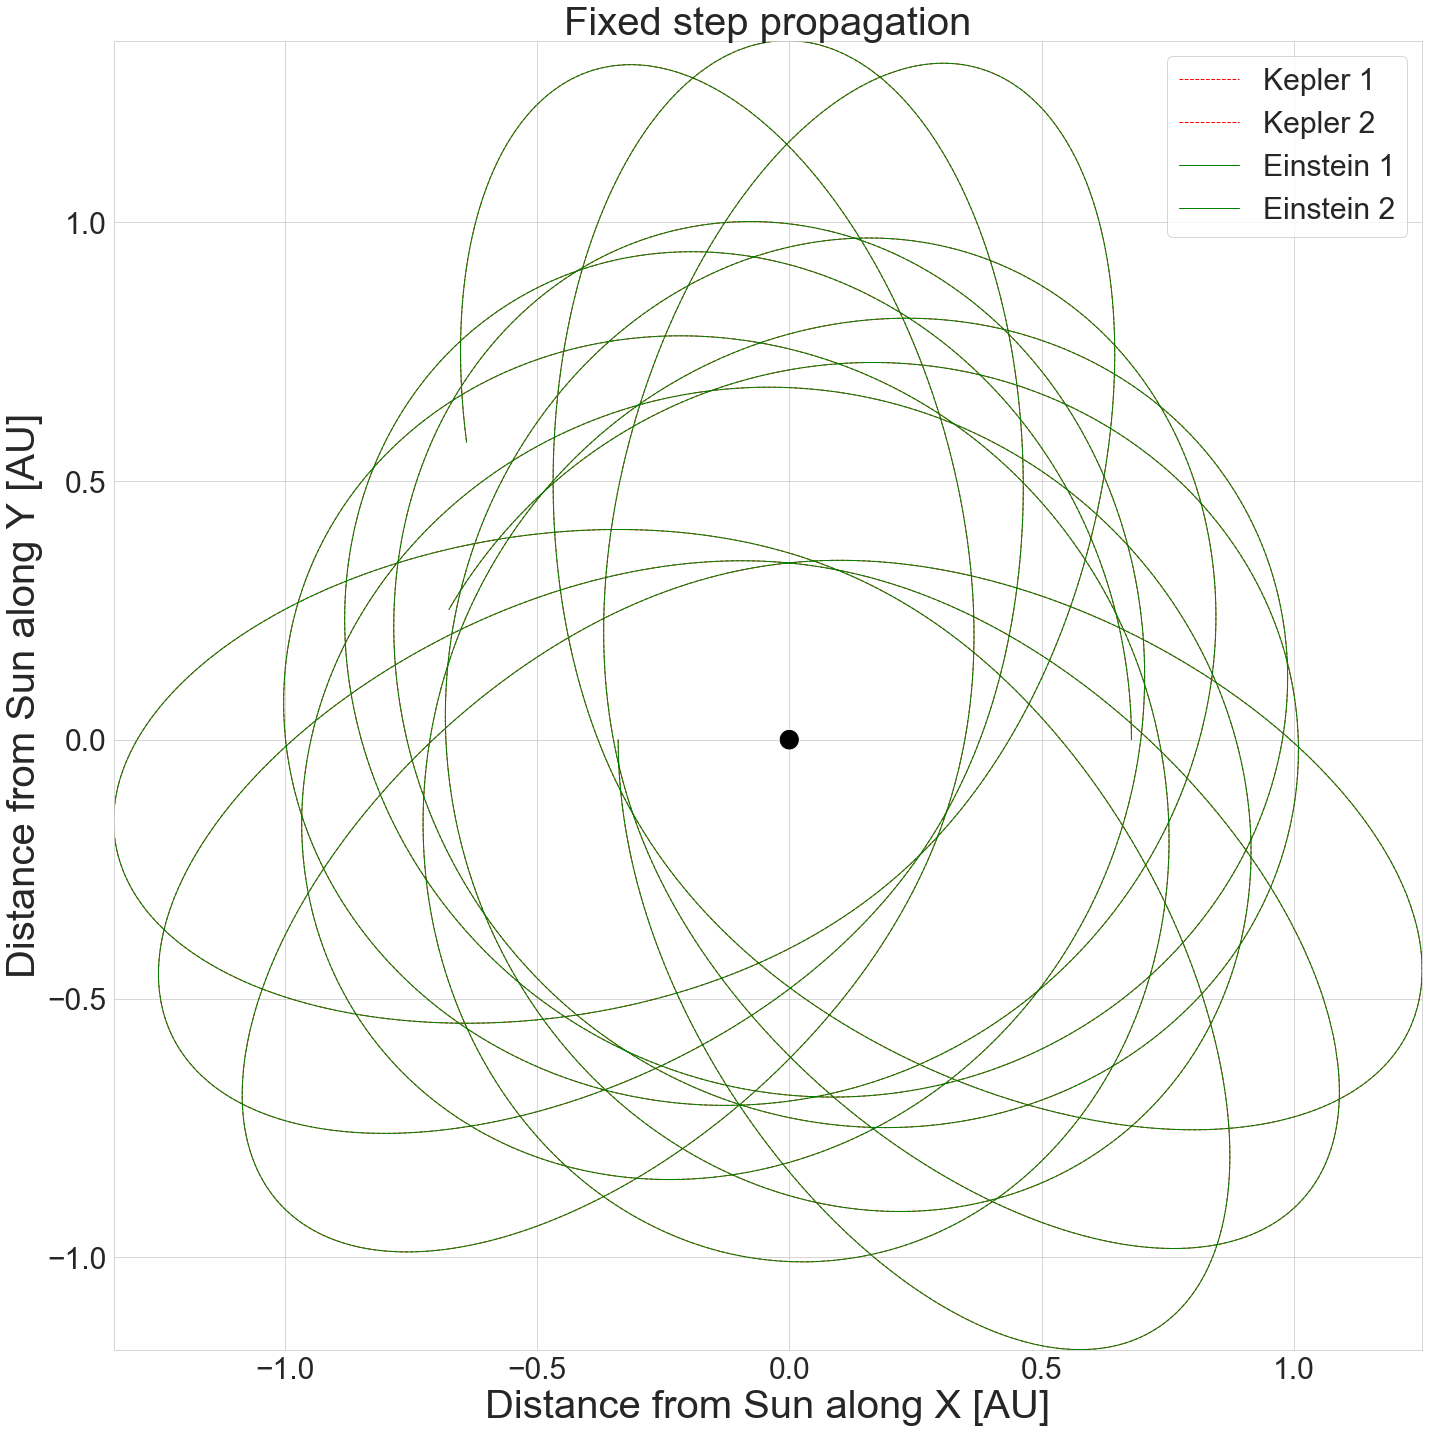

In [77]:
nrows = 1
ncols = 1
picsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(picsize, picsize))

current_mode = mode_choose(mode = 'fixed', relat='no')
os.system(current_mode)
data_fixed = np.genfromtxt('fixed.dat')
axes.plot(data_fixed[::steps,1], data_fixed[::steps,2], c='red', linestyle='--', linewidth=1, label='Kepler 1')
axes.plot(data_fixed[::steps,6], data_fixed[::steps,7], c='red', linestyle='--', linewidth=1, label='Kepler 2')

current_mode = mode_choose(mode = 'fixed', relat='relat')
os.system(current_mode)
data_fixed = np.genfromtxt('fixed.dat')
axes.plot(data_fixed[::steps,1], data_fixed[::steps,2], c='green', linewidth=1, label='Einstein 1')
axes.plot(data_fixed[::steps,6], data_fixed[::steps,7], c='green', linewidth=1, label='Einstein 2')

axes.set_xlim(min(min(data_fixed[::steps,1]), min(data_fixed[::steps,6])),max(max(data_fixed[::steps,1]), max(data_fixed[::steps,6])))
axes.set_ylim(min(min(data_fixed[::steps,2]), min(data_fixed[::steps,7])),max(max(data_fixed[::steps,2]), max(data_fixed[::steps,7])))

axes.set_title('Fixed step propagation', fontsize=40)

axes.set_xlabel('Distance from Sun along X [AU]', fontsize=40)
axes.set_ylabel('Distance from Sun along Y [AU]', fontsize=40)

axes.tick_params(axis='both', which='major', labelsize=30)

CoG = Circle(xy=(0, 0), radius=0.02, fc='k', zorder=10)
axes.add_patch(CoG)

axes.legend(fontsize=30)
fig.tight_layout()
plt.savefig(image_path +
            'two_body_orbit_compare.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

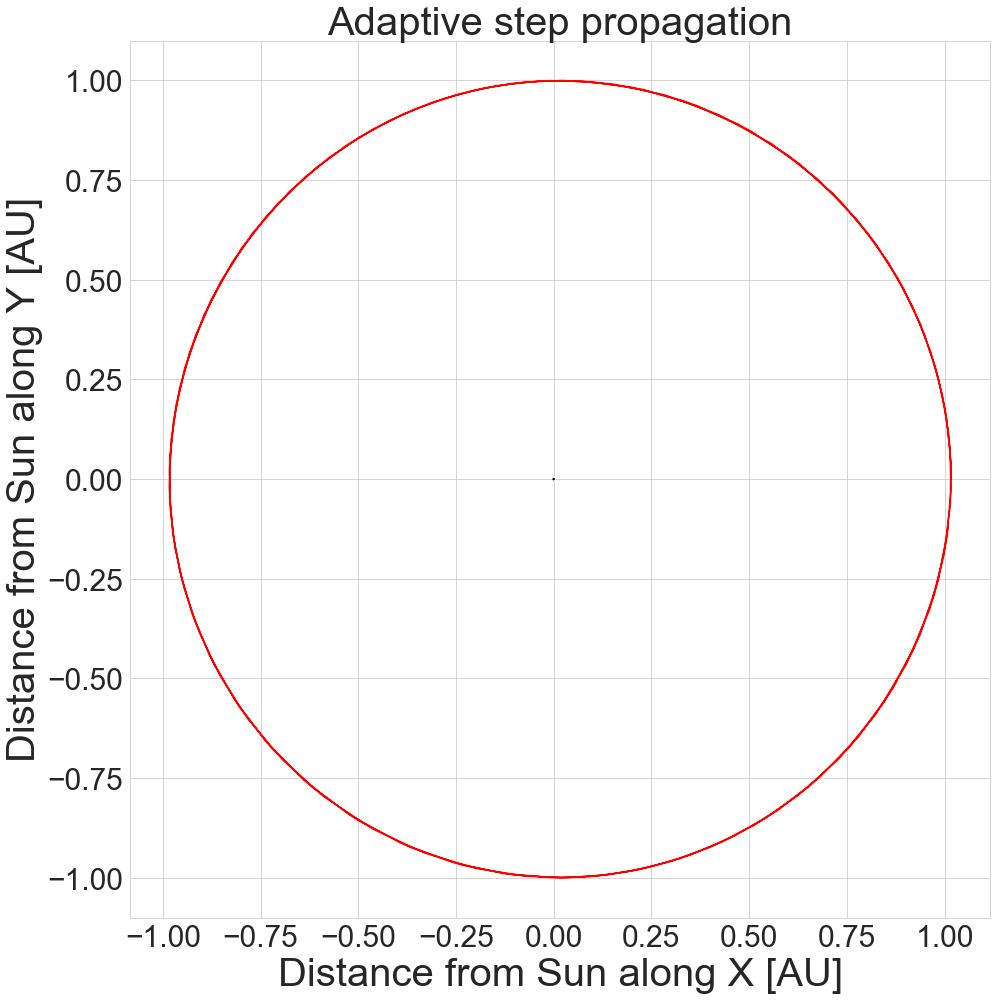

In [189]:
nrows = 1
ncols = 1
picsize = 14
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*(picsize)*(a/b),nrows*picsize))

axes.plot(data_adaptive[::steps,1], data_adaptive[::steps,2], c='red')

axes.set_title('Adaptive step propagation', fontsize=40)

axes.set_xlabel('Distance from Sun along X [AU]', fontsize=40)
axes.set_ylabel('Distance from Sun along Y [AU]', fontsize=40)

axes.tick_params(axis='both', which='major', labelsize=30)

Sun_1 = Circle(xy=(0, 0), radius=0.004649, fc='k', zorder=10)
axes.add_patch(Sun_1)

fig.tight_layout()
'''plt.savefig(image_path +
            'orbit_' + choosen_planet + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')'''
plt.show()

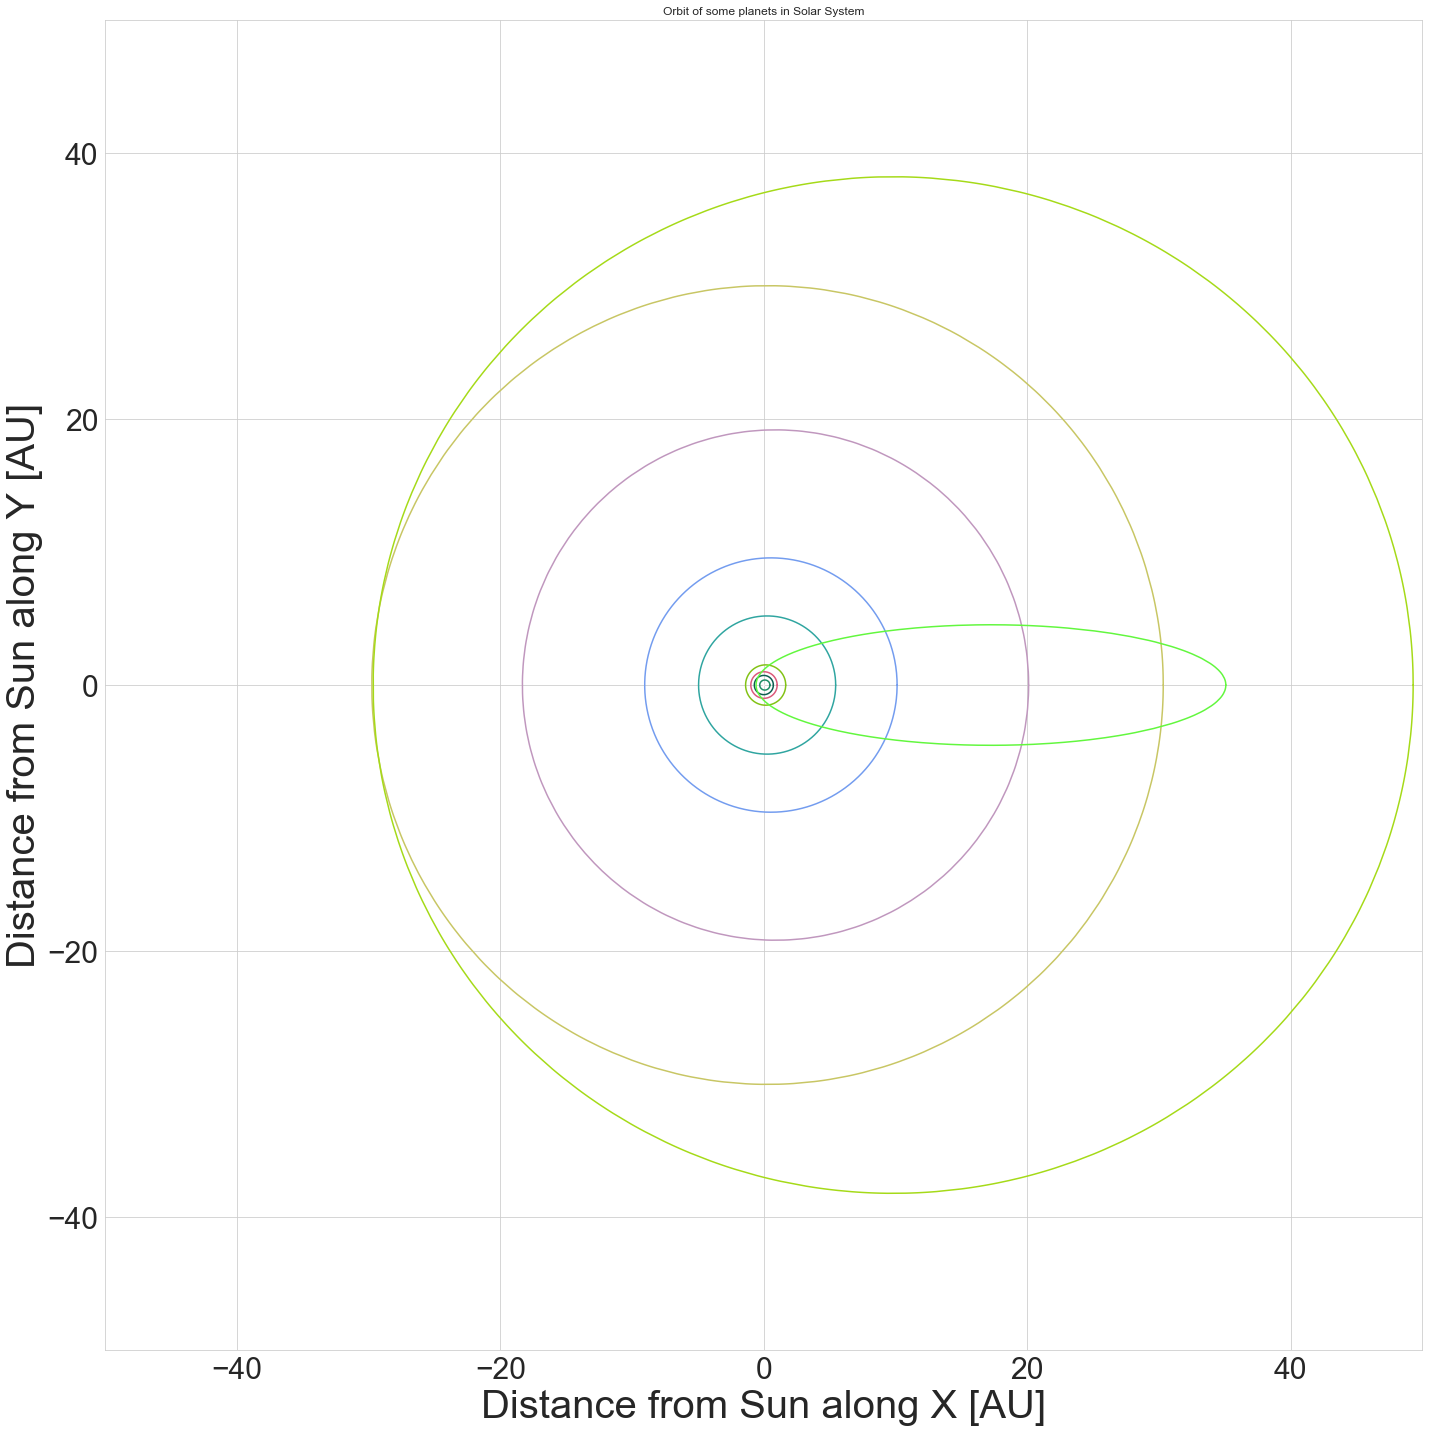

In [19]:
nrows = 1
ncols = 1
picsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*picsize*(a/b),nrows*picsize))

for keys, values in Planets.items():
    if (keys!='Halley'):
        color = np.array((np.random.rand(),np.random.rand(),np.random.rand()))
        # Aphelion distance in AU
        r_ap = Planets[keys][0]
        # Eccentricity
        ecc = Planets[keys][1]
        # Orbital period in [years]
        T = np.power(r_ap / (1 + ecc), 1.5)
        plotting_years = T
        current_mode = mode_choose(mode='fixed')
        os.system(current_mode)
        data_fixed = np.genfromtxt('fixed.dat')
        axes.plot(data_fixed[::steps,1], data_fixed[::steps,2], c=color)

axes.set_title('Orbit of some planets in Solar System')
        
axes.set_xlim(-50,50)
axes.set_ylim(-50,50)
axes.set_xlabel('Distance from Sun along X [AU]', fontsize=40)
axes.set_ylabel('Distance from Sun along Y [AU]', fontsize=40)

axes.tick_params(axis='both', which='major', labelsize=30)

Sun = Circle(xy=(0, 0), radius=0.004649, fc='k', zorder=10)
axes.add_patch(Sun)

fig.tight_layout()
plt.savefig(image_path +
            'orbit_all.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

In [9]:
def ANIMATE_VIDEO(path, video_title, mode):

    if(mode=='both'):
        video_title = 'double_pendulum_both.mp4'
        nrows=1
        ncols=1
        
    elif(mode=='compare'):
        video_title = 'double_pendulum_compare.mp4'
        nrows=1
        ncols=2
        
    else:
        nrows=1
        ncols=1
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*14))

    
    if(mode=='rkck'):
        x1 = coordinates_rkck[::steps,1]
        y1 = coordinates_rkck[::steps,2]
        x2 = coordinates_rkck[::steps,3]
        y2 = coordinates_rkck[::steps,4]

    elif(mode=='runge'):
        x1 = coordinates_runge[::steps,1]
        y1 = coordinates_runge[::steps,2]
        x2 = coordinates_runge[::steps,3]
        y2 = coordinates_runge[::steps,4]
        
    elif(mode=='both' or mode=='compare'):
        x1_rkck = coordinates_rkck[::steps,1]
        y1_rkck = coordinates_rkck[::steps,2]
        x2_rkck = coordinates_rkck[::steps,3]
        y2_rkck = coordinates_rkck[::steps,4]

        x1_runge = coordinates_runge[::steps,1]
        y1_runge = coordinates_runge[::steps,2]
        x2_runge = coordinates_runge[::steps,3]
        y2_runge = coordinates_runge[::steps,4]

    # Pendulum's circle size
    r_1 = 0.05 * np.power(m_1, 1/3)
    r_2 = 0.05 * np.power(m_2, 1/3)
    r = max(r_1, r_2)
    # Plot a trail of the m2 bob's position for the last trail_secs seconds.
    trail_secs = 1
    # This corresponds to max_trail time points.
    max_trail = int(trail_secs / dt)

    ##ANIMATION STUFF BEGINS HERE##

    def animation(i):
            
        if(mode=='both'):
            # Centre the image on the fixed anchor point, and ensure the axes are equal
            ax.set_xlim(-L_1-L_2-r, L_1+L_2+r)
            ax.set_ylim(-L_1-L_2-r, L_1+L_2+r)
            ax.set_aspect('equal', adjustable='box')
            
            # Plot and save an image of the double pendulum configuration for time
            # point i.
            # The pendulum rods.
            ax.plot([0, x1_rkck[i], x2_rkck[i]], [0, y1_rkck[i], y2_rkck[i]], lw=2, c='k')
            ax.plot([0, x1_runge[i], x2_runge[i]], [0, y1_runge[i], y2_runge[i]], lw=2, c='k')
            # Circles representing the anchor point of rod 1, and bobs 1 and 2.
            c0 = Circle((0, 0), 0.05/2, fc='k', zorder=10)
            c1_rkck = Circle((x1_rkck[i], y1_rkck[i]), r_1, fc='red', ec='red', zorder=10)
            c2_rkck = Circle((x2_rkck[i], y2_rkck[i]), r_2, fc='green', ec='green', zorder=10)
            c1_runge = Circle((x1_runge[i], y1_runge[i]), r_1, fc='blue', ec='blue', zorder=10)
            c2_runge = Circle((x2_runge[i], y2_runge[i]), r_2, fc='orange', ec='orange', zorder=10)
            ax.add_patch(c0)
            ax.add_patch(c1_rkck)
            ax.add_patch(c2_rkck)
            ax.add_patch(c1_runge)
            ax.add_patch(c2_runge)

            ax.plot(x1_rkck[0:i], y1_rkck[0:i], c='red', solid_capstyle='butt', lw=2)
            ax.plot(x2_rkck[0:i], y2_rkck[0:i], c='green', solid_capstyle='butt', lw=2)
            ax.plot(x1_runge[0:i], y1_runge[0:i], c='blue', solid_capstyle='butt', lw=2)
            ax.plot(x2_runge[0:i], y2_runge[0:i], c='orange', solid_capstyle='butt', lw=2)
            
            # Don't show axes, only white background
            ax.axis('off')
        
        elif(mode=='compare'):

            # Centre the image on the fixed anchor point, and ensure the axes are equal
            ax[0].set_xlim(-L_1-L_2-r, L_1+L_2+r)
            ax[0].set_ylim(-L_1-L_2-r, L_1+L_2+r)
            ax[0].set_aspect('equal', adjustable='box')
            
            ax[1].set_xlim(-L_1-L_2-r, L_1+L_2+r)
            ax[1].set_ylim(-L_1-L_2-r, L_1+L_2+r)
            ax[1].set_aspect('equal', adjustable='box')
            
            # Plot and save an image of the double pendulum configuration for time
            # point i.
            # The pendulum rods.
            ax[0].plot([0, x1_rkck[i], x2_rkck[i]], [0, y1_rkck[i], y2_rkck[i]], lw=2, c='k')
            ax[1].plot([0, x1_runge[i], x2_runge[i]], [0, y1_runge[i], y2_runge[i]], lw=2, c='k')
            # Circles representing the anchor point of rod 1, and bobs 1 and 2.
            c0_0 = Circle((0, 0), 0.05/2, fc='k', zorder=10)
            c0_1 = Circle((0, 0), 0.05/2, fc='k', zorder=10)
            c1_rkck = Circle((x1_rkck[i], y1_rkck[i]), r_1, fc='red', ec='red', zorder=10)
            c2_rkck = Circle((x2_rkck[i], y2_rkck[i]), r_2, fc='green', ec='green', zorder=10)
            c1_runge = Circle((x1_runge[i], y1_runge[i]), r_1, fc='blue', ec='blue', zorder=10)
            c2_runge = Circle((x2_runge[i], y2_runge[i]), r_2, fc='orange', ec='orange', zorder=10)
            ax[0].add_patch(c0_0)
            ax[1].add_patch(c0_1)
            ax[0].add_patch(c1_rkck)
            ax[0].add_patch(c2_rkck)
            ax[1].add_patch(c1_runge)
            ax[1].add_patch(c2_runge)

            ax[0].plot(x1_rkck[0:i], y1_rkck[0:i], c='red', solid_capstyle='butt', lw=2)
            ax[0].plot(x2_rkck[0:i], y2_rkck[0:i], c='green', solid_capstyle='butt', lw=2)
            ax[1].plot(x1_runge[0:i], y1_runge[0:i], c='blue', solid_capstyle='butt', lw=2)
            ax[1].plot(x2_runge[0:i], y2_runge[0:i], c='orange', solid_capstyle='butt', lw=2)
            
            # Don't show axes, only white background
            ax[0].axis('off')
            ax[1].axis('off')
            
        else:
            # Centre the image on the fixed anchor point, and ensure the axes are equal
            ax.set_xlim(-L_1-L_2-r, L_1+L_2+r)
            ax.set_ylim(-L_1-L_2-r, L_1+L_2+r)
            ax.set_aspect('equal', adjustable='box')
            
            # Plot and save an image of the double pendulum configuration for time
            # point i.
            # The pendulum rods.
            ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
            # Circles representing the anchor point of rod 1, and bobs 1 and 2.
            c0 = Circle((0, 0), 0.05/2, fc='k', zorder=10)
            c1 = Circle((x1[i], y1[i]), r_1, fc='orange', ec='orange', zorder=10)
            c2 = Circle((x2[i], y2[i]), r_2, fc='purple', ec='purple', zorder=10)
            ax.add_patch(c0)
            ax.add_patch(c1)
            ax.add_patch(c2)

            ax.plot(x1[0:i], y1[0:i], c='orange', solid_capstyle='butt', lw=2)
            ax.plot(x2[0:i], y2[0:i], c='purple', solid_capstyle='butt', lw=2)
            
            # Don't show axes, only white background
            ax.axis('off')
        
        
        plt.savefig(path + '_img{:04d}.png'.format(i), dpi=72)    # Save next frame as png
        image = imageio.imread(path + '_img{:04d}.png'.format(i)) # Load saved image
        writer.append_data(image)                                 # Append this image as the next frame to video

        # Clear the pyplot background for the next frame
        if(mode=='compare'):
            ax[0].cla()
            ax[1].cla()
        else:
            plt.cla()
            
        # Delete the now useless image from frames' folder
        os.unlink(path + '_img{:04d}.png'.format(i))

    with imageio.get_writer(video_title, fps=fps) as writer:
        if(mode=='both' or mode=='compare'):
            for i in range(0, len(x1_rkck)):
                sys.stdout.write('\r' + str(i+1) + ' / ' + str(len(x1_rkck)))
                sys.stdout.flush()
                animation(i)
        else:
            for i in range(0, len(x1)):
                sys.stdout.write('\r' + str(i+1) + ' / ' + str(len(x1)))
                sys.stdout.flush()
                animation(i)